# Εργασία 3 ερώτημα Γ

Αν θέλουμε να συνδέσουμε το πρόγραμμα με το google drive ξεσχολιάζουμε τις δύο πρώτες γραμμές.
Στην τρίτη γραμμή βάζουμε το path του dataset που θα χρησιμοποιηθεί για training.
Πρέπει να σημειωθεί ότι αν κάνουμε train και testing με τα ίδια δεδομένα, τα αποτελέσματα μπορεί να είναι διαφορετικά αφού ακόμα και όταν θέσαμε seed δεν υπήρξε ντετερμινισμός

In [1]:
#from google.colab import drive
#drive.mount("/content/drive")

dataset = r'/content/nasdaq2007_17.csv'

import nltk
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from datetime import datetime

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model

from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


import random
import os
import tensorflow as tf
%pylab inline

Mounted at /content/drive
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

reproducibleResults(0)

In [3]:
window_length = 10

Συναρτήσεις που χρησιμοποιήθηκαν για την παρουσίαση των αποτελεσμάτων.Σε περίπτωση που θέλουμε να αλλάξουμε window στη θέση του αριθμού 660 θα πρέπει να μπει ένας αριθμός ο οποίος ισούται με το μέγεθος του set που κάνουμε plot δια 9

In [17]:

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, stock_input.shape[0], 660))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        print(idx)

        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        #plt.savefig('/content/drive/MyDrive/Colab Notebooks/project_3/project_3c_final_ouptuts/final_1_32_comparisons')
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

    #plt.savefig('/content/drive/MyDrive/Colab Notebooks/project_3/project_3c_final_ouptuts/final_1_32_train_test.png')

Διάβασμα του dataset 

In [6]:
import pandas as pd
import numpy as np

df_dataset = pd.read_csv(dataset,delimiter = '\t',header = None)
df_dataset.dropna
df_dataset.reset_index()

#drop column with id's
df_dataset.drop(df_dataset.columns[0],axis=1, inplace=True)
print(df_dataset)

        1        2        3        4     ...    3647    3648    3649    3650
0    11.1440  10.4710  10.8280  10.6980  ...   68.25   68.11   67.47   66.81
1    47.4580  45.8700  46.2490  47.8520  ...   46.97   45.89   43.33   43.01
2    13.8800  12.9700  13.2900  13.0900  ...   72.22   71.16   70.19   70.56
3     1.2037   1.1589   1.1385   1.1437  ...  174.18  175.61  175.25  174.67
4    13.9910  13.4340  13.1950  13.4150  ...   74.91   75.01   75.27   75.00
..       ...      ...      ...      ...  ...     ...     ...     ...     ...
354  17.2850  16.9010  17.0160  17.4210  ...   64.38   64.52   65.56   65.58
355  36.3880  35.2030  35.7070  35.1040  ...   28.59   29.37   29.27   29.17
356   8.2660   8.3172   8.2781   8.3591  ...   81.01   81.13   79.53   79.59
357  46.3950  45.8150  42.1810  41.5820  ...  108.72  109.17  111.84  110.75
358  47.6690  46.6680  46.5700  46.9740  ...   44.88   44.55   43.97   43.93

[359 rows x 3650 columns]


Μετατροπή του dataset σε numpy και ένωση όλων των χρονοσειρών σε μία με την εντολή flatten()

In [7]:
df_data = df_dataset.to_numpy()
print(df_data[0])

df_data=df_data.flatten()
print(df_data.shape)
df_data = df_data.reshape(df_data.shape[0],1)
print(df_data.shape)



[11.144 10.471 10.828 ... 68.11  67.47  66.81 ]
(1310350,)
(1310350, 1)


H χρονοσειρά πριν το scaling

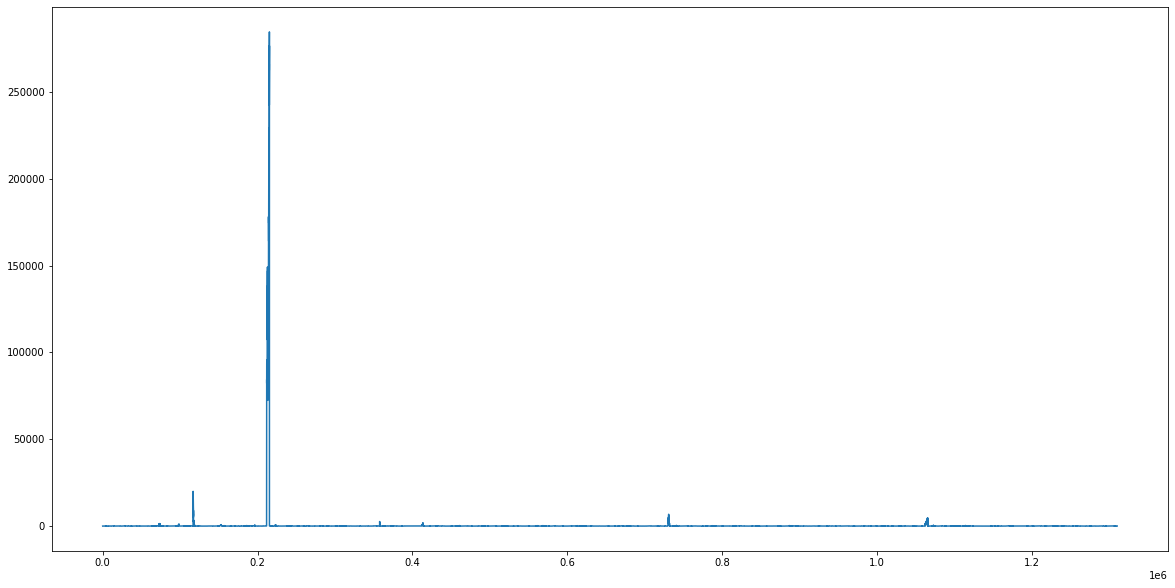

In [8]:
plt.figure(figsize=(20,10))
plt.plot(np.array(df_data))

Κρατάμε 95% της χρονοσειράς για training και 5% για testing ενώ κάνουμε και scaling

(1244832, 1) (65518, 1)


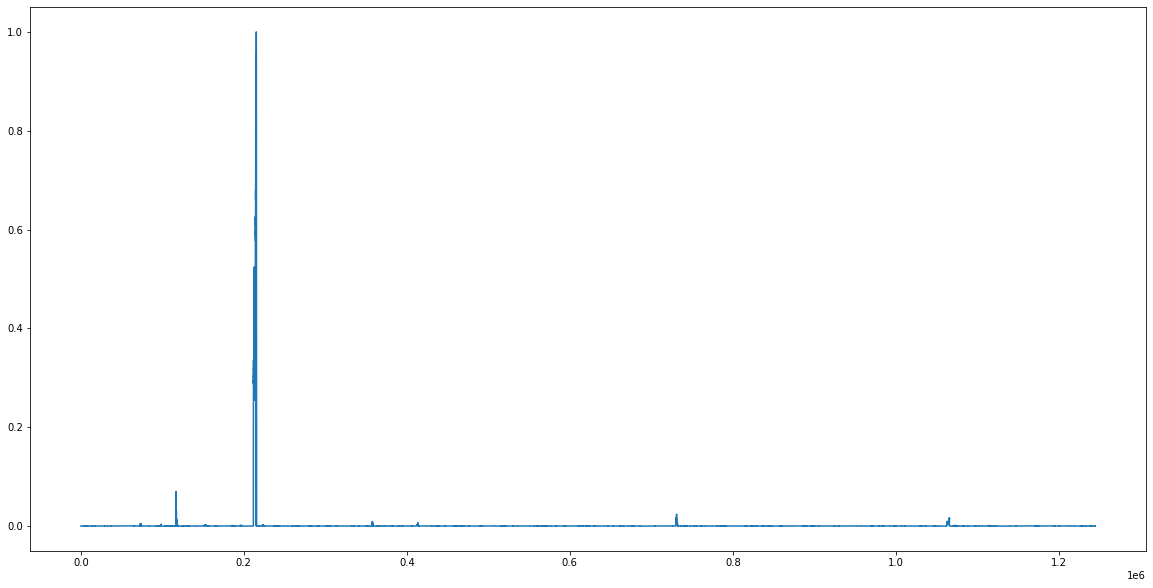

In [9]:
from sklearn.preprocessing import MinMaxScaler


train_size = int(len(df_data) * 0.95)
test_size = len(df_data) - train_size
train, test = df_data[0:train_size], df_data[train_size:len(df_data)]

scaler = MinMaxScaler()

scaler = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

plt.figure(figsize=(20,10))
plt.plot(np.array(train))


print(train.shape, test.shape)

Τρέχουμε αυτό το κελί αν θέλουμε να αποθηκεύσουμε τον scaler και φτιάχνουμε το μονοπάτι

In [ ]:
from pickle import dump

dump(scaler, open('/content/drive/MyDrive/Colab Notebooks/project_3/scaler_3c.pkl', 'wb'))

Συναρτήσεις για τον χωρισμό των windows

In [10]:
#this functions is used if we want to split X in shifted timesteps
def create_dataset2(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#this functions is used if we want to split X in windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(0,len(X) - time_steps,time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)



def windowing(X,window_size=1):
    Xs = []
    for i in range(0,len(X) - window_size,window_size):
        v = X[i:(i + window_size)]
        Xs.append(v)
    return np.array(Xs)


Χωρισμός των set σε windows και προετοιμασια για να μπουν στο μοντέλο έχοντας διαστάσεις  [samples, window_length, n_features] όπου n_features = 1

In [11]:
X_train = []
y_train = []

# reshape to [samples, window_length, n_features]
X_train, y_train = create_dataset( train,train,window_length)

# reshape to [samples, window_length, n_features]
X_test, y_test = create_dataset( test,test,window_length)


print(X_train.shape)
print(y_train.shape)
y_train.reshape(y_train.shape[0])
y_test.reshape(y_test.shape[0])
print(X_test.shape)
print(y_test.shape)




(124483, 10, 1)
(124483, 1)
(6551, 10, 1)
(6551, 1)


Αν θέλουμε να χρησιμοποιήσουμε GPU τρέχουμε αυτόν τον κώδικα

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


To μοτέλο στο οποίο καταλήξαμε μετά από πολλές δοκιμές οι οποίες περιγράφται στο readme

In [12]:

input_window = Input(shape=(window_length,1))
x = Conv1D(64, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(32, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims

x = Conv1D(32, 3, activation="relu", padding="same")(x) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(64, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims

decoder = Model(encoded,decoded)

autoencoder = Model(input_window, decoder(encoder(input_window)))
#autoencoder = Model(input_window, decoded)
autoencoder.summary()

encoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(X_train, X_train,
epochs=20,
batch_size=64,
shuffle=True,
validation_data=(X_test, X_test))

decoded_stocks = autoencoder.predict(X_test)
print(decoded_stocks.shape)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 model (Functional)          (None, 3, 1)              6529      
                                                                 
 model_1 (Functional)        (None, 10, 1)             4485      
                                                                 
Total params: 11,014
Trainable params: 11,014
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1946/1946 [==============================] - 26s 5ms/step - loss: 0.0222 - val_loss: 0.0015
Epoch 2/20
1946/1946 [==============================] - 10s 5ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 3/20
1946/1946 [==============================] - 10s 5ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 4/20

Πρόβλεψη για το testing

In [14]:
compressed = encoder.predict(X_test)
print(compressed.shape)

(6551, 3, 1)


Aν θέλουμε να σώσουμε το μοντέλο τότε βάζουμε το path που θέλουμε και τρέχουμε αυτό το κελί

In [ ]:

autoencoder.save('/content/drive/MyDrive/Colab Notebooks/project_3/final_1_32_autoencoder3_c')
encoder.save('/content/drive/MyDrive/Colab Notebooks/project_3/final_1_32_encoder3_c')




INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project_3/final_1_32_autoencoder3_c/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project_3/final_1_32_encoder3_c/assets


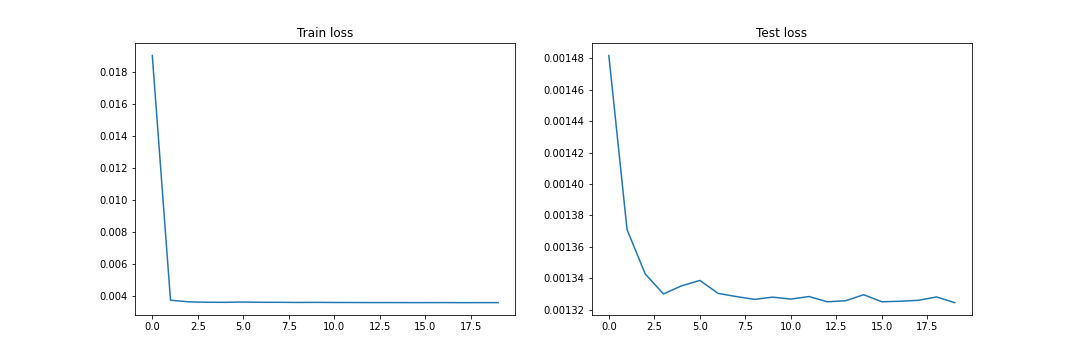

In [20]:
plot_history(history)

Διαγράμματα ανακατασκευής παραθύρων 

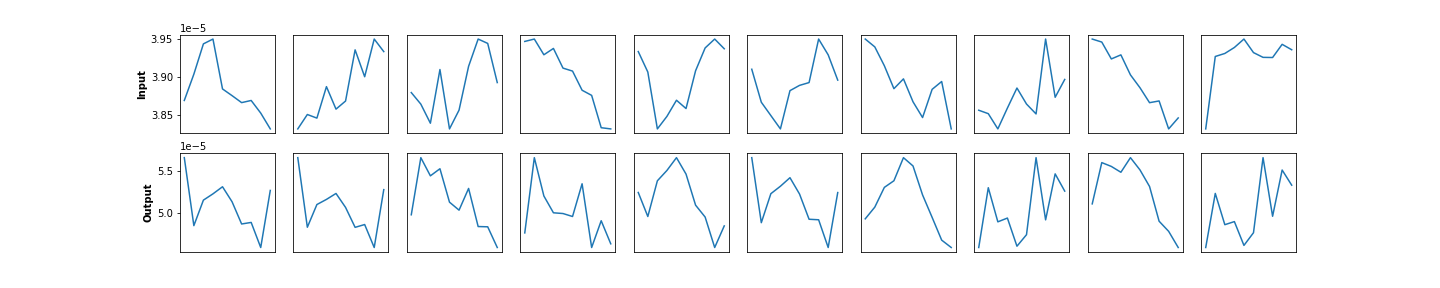

In [19]:
plot_examples(X_test, decoded_stocks)